# LSTM for KOSPI Forecasting Example

In [1]:
import numpy as np 
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# to set data path
dataPath = 'https://raw.githubusercontent.com/stillxyxon/py_ml_analysis/master/'
# dataPath = 'C:/YONG/m1710/myPydata/'

# https://www.kaggle.com/amarpreetsingh/stock-prediction-lstm-using-keras/notebook 

Using TensorFlow backend.


### Data Loading 

In [207]:
# 
data = pd.read_csv(dataPath + 'kospi_20191003.csv',
                  parse_dates=['date'],
                   index_col=['date'])
print(data.columns)
print(data.tail())

cl0 = data.kospi

Index(['kospi', 'trxcnt', 'amt'], dtype='object')
            kospi  trxcnt      amt
date                              
2019-09-26   2075  430577  4656831
2019-09-27   2050  285943  3489261
2019-09-30   2063  327625  3709169
2019-10-01   2072  389336  3869998
2019-10-02   2032  414460  3933922


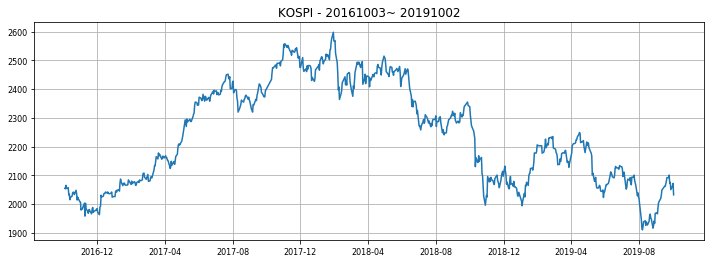

In [208]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.plot(cl0)
ax.grid()
plt.title('KOSPI - 20161003~ 20191002')
ax.tick_params(axis='both', labelsize=8)
plt.show()

In [209]:
# get deviations from the previous day

print(cl0.head())
cl_startval = cl0[0]
print(cl_startval)
cl = cl0.subtract(cl0.shift(1))
cl = cl[1:]
print(len(cl))
print(cl.tail())
print(cl0.tail())

date
2016-10-04    2055
2016-10-05    2053
2016-10-06    2065
2016-10-07    2054
2016-10-10    2057
Name: kospi, dtype: int64
2055
735
date
2019-09-26     2.0
2019-09-27   -25.0
2019-09-30    13.0
2019-10-01     9.0
2019-10-02   -40.0
Name: kospi, dtype: float64
date
2019-09-26    2075
2019-09-27    2050
2019-09-30    2063
2019-10-01    2072
2019-10-02    2032
Name: kospi, dtype: int64


### Data Preparation

72.0 -99.0


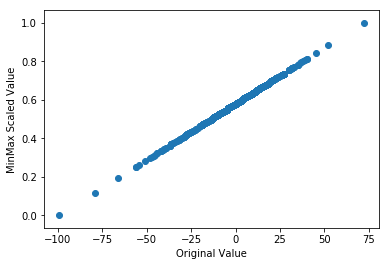

In [210]:
# Scale the data

cl_orgnl = cl.copy()
cl_train = cl[:(len(cl)-90)]
clt_max, clt_min = cl_train.max(), cl_train.min()
print(clt_max, clt_min)

cl = np.array(cl).reshape(cl.shape[0],1)
cl = (cl - clt_min) / (clt_max-clt_min)


# What is MinMax Scaling?

plt.scatter(cl_orgnl, cl)
plt.xlabel('Original Value')
plt.ylabel('MinMax Scaled Value')
plt.show()


- scaler는 지정된 구간에서(train set) 기준값을 구해야함 
(후에 사용할 테스트 기간, 실제 운영시 새로운 데이터 투입 처리 용으로)
- 운영상황의 예측에서는 신규 데이터가 들어오며 (데이터 추가, 데이터셋 이동), 미래 장기간을 예측하는 경우라면 예측을 input으로 해서 예측을 계속하는 방안 밖에 없음

In [240]:
# a user function to process the data into 7 day look back(=lb) slices

def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

lb = 10 # [5, 10, 15]
X,y = processData(cl,lb) # lb = look back period in days

# 최근 60개 일자의 값은 테스트용으로
# 테스트 이전 30개 값은 Validation 용으로 모델링중 사용

print(len(y), len(y)-60, len(y)-90)
a, b, c = len(y), len(y)-60, len(y)-90 
X_train, X_val, X_test = X[:c], X[c:b],X[b:]
y_train, y_val, y_test = y[:c], y[c:b],y[b:]

print('Train set :', X_train.shape[0], y_train.shape[0])
print('Validation set :', X_val.shape[0], y_val.shape[0])
print('Test set :', X_test.shape[0], y_test.shape[0])

print('\nTraining Set : \n', X_train[:3])
# slides one day

724 664 634
Train set : 634 634
Validation set : 30 30
Test set : 60 60

Training Set : 
 [[0.56725146 0.64912281 0.51461988 0.59649123 0.43274854 0.59064327
  0.46783626 0.62573099 0.60818713 0.64912281]
 [0.64912281 0.51461988 0.59649123 0.43274854 0.59064327 0.46783626
  0.62573099 0.60818713 0.64912281 0.58479532]
 [0.51461988 0.59649123 0.43274854 0.59064327 0.46783626 0.62573099
  0.60818713 0.64912281 0.58479532 0.57894737]]


### Model Building

In [212]:
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

# Build the model
model = Sequential()
model.add(LSTM(128,input_shape=(lb,1), return_sequences = True, recurrent_dropout=0.1))
model.add(LSTM(128, return_sequences = True, recurrent_dropout=0.1))
model.add(LSTM(128, recurrent_dropout=0.1))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mae')

#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=100,
                    validation_data=(X_val,y_val),shuffle=True, batch_size = 16)


Train on 634 samples, validate on 30 samples
Epoch 1/100
634/634 [==============================] - 8s 12ms/step - loss: 0.1508 - val_loss: 0.0794
Epoch 2/100
634/634 [==============================] - 3s 5ms/step - loss: 0.0854 - val_loss: 0.0679
Epoch 3/100
634/634 [==============================] - 3s 5ms/step - loss: 0.0810 - val_loss: 0.0570
Epoch 4/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0779 - val_loss: 0.0580
Epoch 5/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0817 - val_loss: 0.0750
Epoch 6/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0797 - val_loss: 0.0579
Epoch 7/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0867 - val_loss: 0.0561
Epoch 8/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0808 - val_loss: 0.0645
Epoch 9/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0786 - val_loss: 0.0553
Epoch 10/100
634/634 [=======================

Epoch 81/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0752 - val_loss: 0.0611
Epoch 82/100
634/634 [==============================] - 3s 5ms/step - loss: 0.0751 - val_loss: 0.0549
Epoch 83/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0744 - val_loss: 0.0547
Epoch 84/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0745 - val_loss: 0.0547
Epoch 85/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0755 - val_loss: 0.0605
Epoch 86/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0751 - val_loss: 0.0559
Epoch 87/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0749 - val_loss: 0.0546
Epoch 88/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0745 - val_loss: 0.0556
Epoch 89/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0745 - val_loss: 0.0539
Epoch 90/100
634/634 [==============================] - 3s 4ms/step - loss: 0.0757

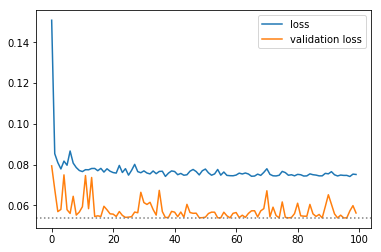

min 1% loss (loss, val_loss) :  0.074233930142661 0.05387918019791444
mean of last 10 losses (loss, val_loss) :  0.07506392150529739 0.057204958051443114


In [213]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'validation loss'], loc='upper right')
plt.axhline(np.percentile(history.history['val_loss'],5), color='grey',
           linestyle=':')
plt.show()

# 작은순 1% loss 지점은? - 일회성의 큰 변동을 무시하기 위한 방안
print('min 1% loss (loss, val_loss) : ', np.percentile(history.history['loss'],1), np.percentile(history.history['val_loss'],1))
# 마지막 10개 epoch의 loss 평균값은?
print('mean of last 10 losses (loss, val_loss) : ', np.mean(history.history['loss'][-10:]), np.mean(history.history['val_loss'][-10:]))

### Assessment of LSTM Predictions

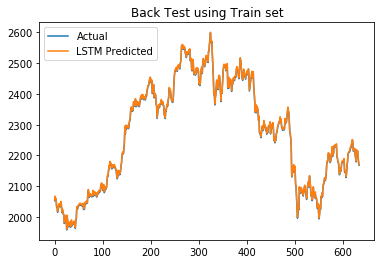

MAE :  2.6555037874528664


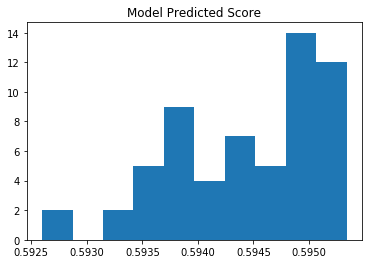

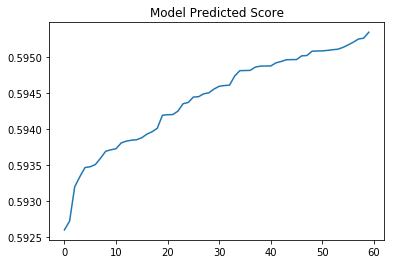

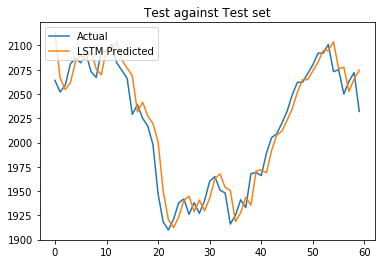

MAE :  14.279926172892253


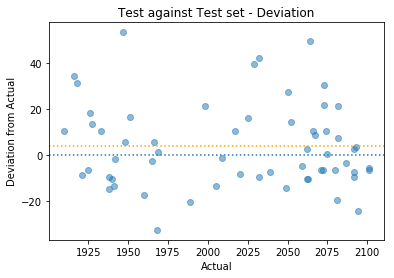

In [239]:
# 예측과 실제를 비교하는 챠트를 생성하는 함수
# 데이터셋을 변경하는 경우에도 재사용

def PredActPlot(x, y, title):
    y = list(cl0[:(len(y)+1)])
    plt.plot(y[1:])
    Xt = model.predict(x)
    Xt = (Xt * (clt_max-clt_min)) + clt_min
    Xt = y[1:] + Xt.reshape(-1,)
    plt.plot(Xt)
    plt.legend(['Actual', 'LSTM Predicted'], loc='upper left')
    plt.title(title)
    plt.show()

    print('MAE : ' , abs(y[1:] - Xt).mean())
    

PredActPlot(X_train, y_train, 'Back Test using Train set')    


test_prev = list(cl0[-(60+1):])[:60]  
test_actual = list(cl0[-(60):])
Xt = model.predict(X_test).reshape(-1,)
Xta = Xt.reshape(-1,)
Xt = (Xt * (clt_max-clt_min)) + clt_min
test_predicted = test_prev + Xt


plt.hist(Xta)
plt.title('Model Predicted Score')
plt.show()

plt.plot(np.sort(Xta))
plt.title('Model Predicted Score')
plt.show()


# 데이터셋을 변경하는 경우에도 재사용 고려해서 함수화

def PredActPlot(x, y, title, dstype):
    plt.plot(test_actual)
    plt.plot(test_predicted)
    plt.legend(['Actual', 'LSTM Predicted'], loc='upper left')
    plt.title(title)
    plt.show()

    print('MAE : ' , abs(test_predicted - test_actual).mean())
    
    
PredActPlot(X_test, y_test, 'Test against Test set', 'test')   

def PredActDevPlot(x, y, title):    
    plt.scatter(test_actual, test_predicted - test_actual, alpha=0.5)
    plt.axhline(0, linestyle=':')
    plt.axhline(np.mean(test_predicted - test_actual), linestyle=':',
               color='orange')
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Deviation from Actual')
    plt.show()
     
PredActDevPlot(X_test, y_test, 'Test against Test set - Deviation')       

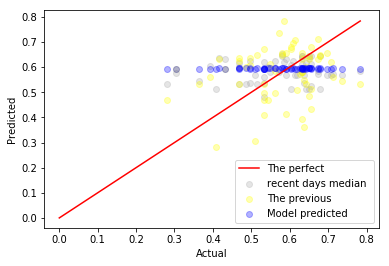

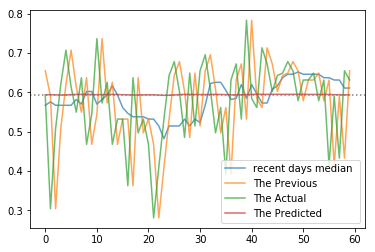

Abs Error of the previous :  14.383333333333333 
Abs Error of the recent days median :  14.516666666666667 
Abs Error of the predicted :  14.279926172892253


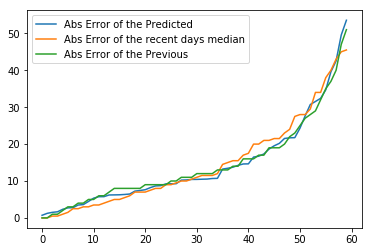

In [234]:
# a scatter plot of median of past 7 days and the target?
# a scatter plot of the previous day and the target?

X_prv = X_test[:,X_test.shape[1]-1,:].reshape(-1,)

plt.scatter(y_test, np.median(X_test, axis=1), alpha=0.3, color='darkgrey')
plt.scatter(y_test, X_prv, alpha=0.3, color='yellow')
plt.scatter(y_test, Xta, alpha=0.3, color='blue')
plt.plot([0,y_test.max()],[0,y_test.max()], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(['The perfect','recent days median ','The previous', 'Model predicted'])
plt.show()



plt.plot(np.median(X_test, axis=1), alpha=0.7)
plt.plot(X_prv, alpha=0.7)
plt.plot(y_test, alpha=0.7)
plt.plot(Xta, alpha=0.7)
plt.legend(['recent days median ','The Previous', 'The Actual', 'The Predicted'])
plt.axhline(Xta.mean(), color='grey', linestyle=":")
plt.show()

test_med_pst = (np.median(X_test, axis=1).reshape(-1) * (clt_max-clt_min)) + clt_min  + test_prev 

print('Abs Error of the previous : ', abs(np.array(test_prev)  - np.array(test_actual)).mean(), 
      '\nAbs Error of the recent days median : ', abs(np.array(test_med_pst) - np.array(test_actual)).mean(),
      '\nAbs Error of the predicted : ', abs(test_predicted - test_actual).mean())
     

plt.plot(np.sort(abs(test_predicted - test_actual)))
plt.plot(np.sort(abs(np.array(test_med_pst)  - np.array(test_actual))))
plt.plot(np.sort(abs(np.array(test_prev)  - np.array(test_actual))))
plt.legend(['Abs Error of the Predicted', 'Abs Error of the recent days median', 'Abs Error of the Previous'])
plt.show()

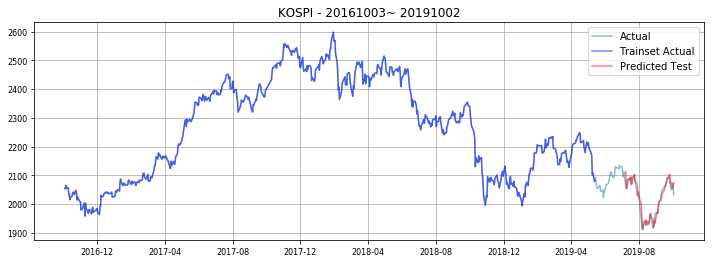

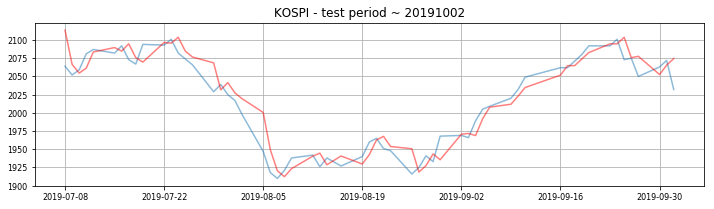

In [232]:
clpred = cl0[-60:].copy()
clpred.loc[:] = test_predicted

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.plot(cl0, alpha=0.5)
ax.plot(cl0[:639], color='blue', alpha=0.5)
ax.plot(clpred, color='red', alpha=0.5)
ax.grid()
plt.title('KOSPI - 20161003~ 20191002')
ax.tick_params(axis='both', labelsize=8)
plt.legend(['Actual','Trainset Actual', 'Predicted Test'])
plt.show()


fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax.plot(cl0[-60:], alpha=0.5)
ax.plot(clpred, color='red', alpha=0.5)
ax.grid()
plt.title('KOSPI - test period ~ 20191002')
ax.tick_params(axis='both', labelsize=8)
plt.show()


[예측결과 종합]
- 전날 값 (최근) 의 영향을 받을 수 밖에 없기에 이미 전날 값을 뒤따라가는 패턴과 상당히 유사한 예측결과
- 자기 시계열만으로는 전날 값에서 변화하는 변동을 많이 설명하지 못함
- 하지만, 전날값이 불변한다고 가정하는 것에 비해서는 오차 적음
- 값 자체에 대한 예측에서는 전날을 이기지 못한 것에 비해서는 전날로부터의 변화를 예측하는 방식으로 오차 감소